
![](http://sdcsb.ucsd.edu/wp-content/themes/sdcsb_theme/images/sdcsb_logo.png)

# SDCSB Tutorial
### Advanced Cytoscape: Cytoscape, IPython, Docker, and reproducible network data visualization workflows

Friday, 4/17/2015 at Sanford


### Lesson 2: Visualization with Cytoscape and Cytoscape.js

by [Keiichiro Ono](http://keiono.github.io/)

----

![](http://cl.ly/aKS1/tca1.png)


## Background 
You can visualize network data set using easy-to-use Cytoscape GUI and you can save the final result as a ___session file___.  But if you need to create similar visualizations, you need to repeat the manual (point-and-click) operations again.  This will be more and more time consuming process as your data sets grows.  Good news is, you can avoid it by writing your visualization workflow as Notebooks!

In [1]:
import requests
import json
from IPython.display import Image
import pandas as pd

# Basic Setup
PORT_NUMBER = 1234
IP = '137.110.137.158' # Dont' forget to update this!!!!!!!!!!!!!!!
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}

# Utulity to POST object
def create(param, dict_data):
    return requests.post(BASE + param, data=json.dumps(dict_data), headers=HEADERS)

def update(param, dict_data):
    return requests.put(BASE + param, data=json.dumps(dict_data), headers=HEADERS)
    
# Start from a clean slate!
requests.delete(BASE + 'session')

<Response [200]>

## Visual Style

![](http://cl.ly/aJam/visualstyles.png)

To visuaize your data with Cytoscape, you need to understand its data-to-view mapping mechanism called ___Visual Style___.

### What is a Visual Style?
__Visual Style is a collection of instructions how to map your data to visual properties (or visual variables)__.  To use it to make effective visualizations, you need to understand the following concepts.

In [2]:
# Get a list of all available Visual Styles
vs_url = BASE + 'styles'
res = requests.get(vs_url)
style_df = pd.DataFrame(res.json(), columns=['Style Name'])
style_df

Style Name
0    default

#### Visual Properties
Visual Properties, sometimes called [visual variables](http://www.infovis-wiki.net/index.php?title=Visual_Variables) in other applications, are properties of viewable objects, such as color, shape, opacity, size, etc.

You can get the complete list of Visual Properties with the following code:

In [3]:
vps_url = BASE + 'styles/visualproperties'
print(vps_url)

# Let's make it a bit more human readable
res = requests.get(vps_url)
vp_df = pd.DataFrame(res.json(), columns=['visualProperty', 'name', 'targetDataType', 'default'])
vp_df.tail()

http://137.110.137.158:1234/v1/styles/visualproperties


visualProperty             name targetDataType default
98      NODE_VISIBLE     Node Visible         CyNode    true
99        NODE_WIDTH       Node Width         CyNode    60.0
100  NODE_X_LOCATION  Node X Location         CyNode     0.0
101  NODE_Y_LOCATION  Node Y Location         CyNode     0.0
102  NODE_Z_LOCATION  Node Z Location         CyNode     0.0

##### Discrete Range Values
Some of the Visual Properties have set of disrete values.  You can access those by _values_ API:

In [4]:
res = requests.get(vps_url + '/NODE_SHAPE/values')
node_shapes = pd.DataFrame(res.json()['values'], columns=['Node Shapes'])
node_shapes

Node Shapes
0    PARALLELOGRAM
1  ROUND_RECTANGLE
2          OCTAGON
3         TRIANGLE
4          ELLIPSE
5          HEXAGON
6        RECTANGLE
7          DIAMOND
8              VEE

#### Defaults
By default, there is no mapping from your data to Visual Properties.  __If there is no mapping for a Visual Property, default value will be used.__

In [5]:
directed_style_url = BASE + 'styles/default/defaults'
print(directed_style_url)

res = requests.get(directed_style_url)
defaults_df = pd.DataFrame(res.json()['defaults'], columns=['visualProperty', 'value'])
defaults_df.head()

http://137.110.137.158:1234/v1/styles/default/defaults


visualProperty            value
0             EDGE_BEND                 
1           EDGE_CURVED             True
2            EDGE_LABEL                 
3      EDGE_LABEL_COLOR          #000000
4  EDGE_LABEL_FONT_FACE  Dialog,plain,10

Let's try with actual network data.

In [6]:
# Load a network file
f = open('data/yeast.json', 'r')
cyjs_network = json.load(f)
cyjs_network['data']['name'] = 'Yeast 1' 

res = create('networks', cyjs_network)
suid = res.json()['networkSUID']

# Apply Visual Style "default"
requests.get(BASE + 'apply/styles/default')
requests.get(BASE + 'apply/layouts/degree-circle/' + str(suid))

paints = defaults_df[defaults_df['visualProperty'].str.contains('COLOR')]

paints.tail(10)

visualProperty    value
3   EDGE_LABEL_COLOR  #000000
77   NODE_FILL_COLOR  #0099CC
80  NODE_LABEL_COLOR  #FFFFFF

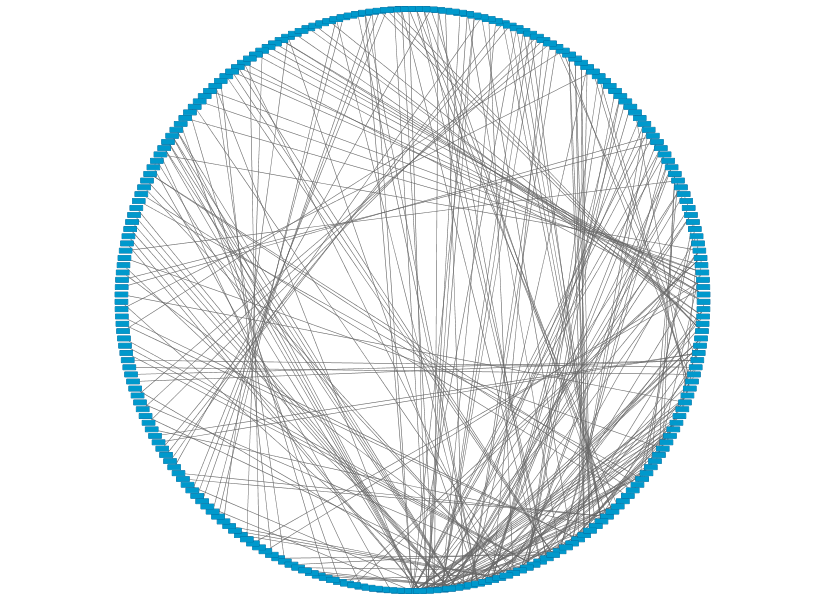

In [7]:
Image(BASE+'networks/' + str(suid) + '/views/first.png')

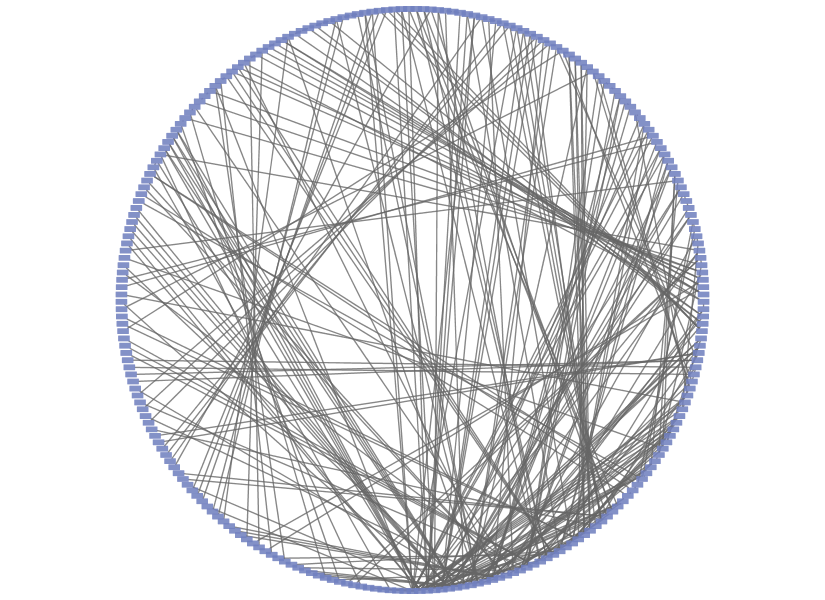

In [8]:
# Let's change some default values.
new_values = [
    {
        'visualProperty':'NODE_FILL_COLOR',
        'value': '#7080BF'
    },
    {
        'visualProperty':'NODE_BORDER_WIDTH',
        'value': 0
    },
    {
        'visualProperty':'NODE_LABEL_FONT_SIZE',
        'value': 90
    },
    {
        'visualProperty':'NODE_WIDTH',
        'value': 60
    },
    {
        'visualProperty': 'EDGE_WIDTH',
        'value': 7
    },
    {
        'visualProperty': 'NODE_TRANSPARENCY',
        'value': 220
    },
    {
        'visualProperty': 'EDGE_TRANSPARENCY',
        'value': 200
    }
]

update('styles/default/defaults', new_values)
Image(BASE+'networks/' + str(suid) + '/views/first.png')

### Excercise: Update default Values
* Node Color
* Edge Width
* Node Shape


In [9]:
# Write your code here...

#### Mappings
Mappings , or Visual Mapping Functions, are the actual mechanism to map data points to Visual Property values.  There are three types of mappings: discrete, continuous, and passthrough.

##### Passthrough
___Passthrough Mapping___ is the simplest mapping mechanism in Cytoscape.  It simply map values to Visual Property.  For example, if you create a node name to node label mapping, it simply passes the node name text to the Mapping Function and displays as node label. 

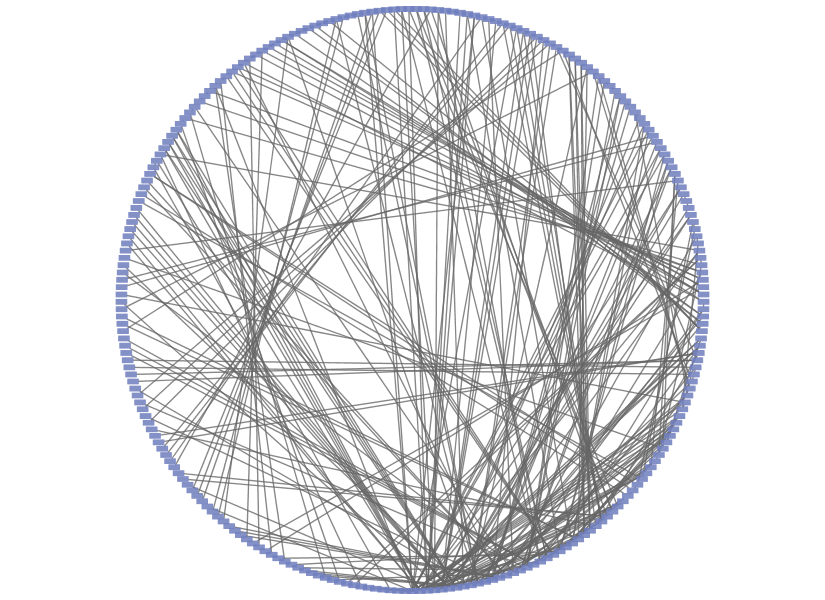

In [10]:
# Create a Passthrough mapping
new_passthrough_mapping = {
    'mappingType': 'passthrough',
    'mappingColumn': 'degree.layout',
    'mappingColumnType': 'Integer',
    'visualProperty': 'NODE_LABEL',
}

# Create a new style by POSTing the object
create('styles/default/mappings', [new_passthrough_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

##### Discrete
Discrete mapping is the one maps discrete data points to any Visual Properties.  Here is the list of typical discrete mappings:

* Node type (gene, protein complex, small compounds, etc.) to node shape
* Node type to size
* Interaction type (inhibition / activation) to arrow shape
* Interaction detection method (Y2H, co-expression, text mining, etc.) to edge line style

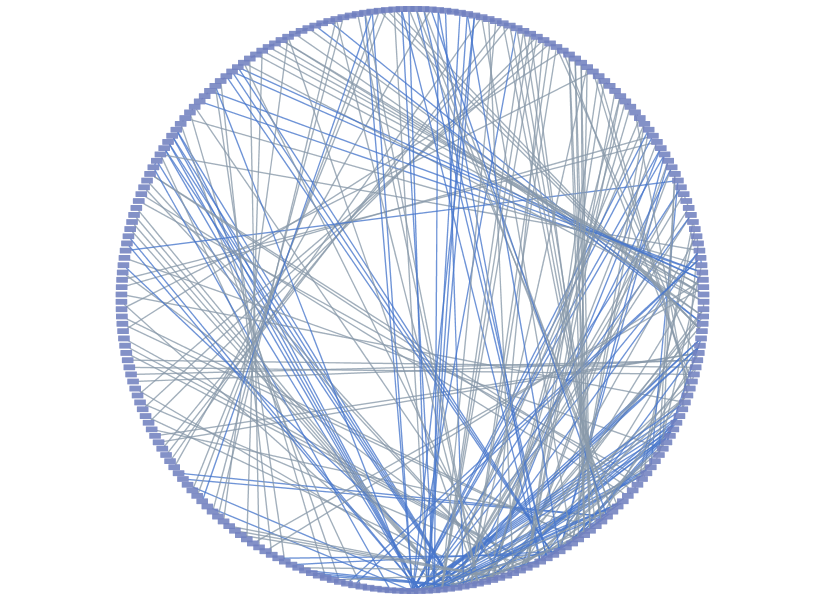

In [11]:
# Create discrete mapping
new_disc_mapping = {
    'mappingType': 'discrete',
    'mappingColumn': 'interaction',
    'mappingColumnType': 'String',
    'visualProperty': 'EDGE_STROKE_UNSELECTED_PAINT',
    'map':[
        {
            'key': 'pp',
            'value': '#8899aa'
        },
        {
            'key': 'pd',
            'value': '#4876cc'
        }
    ]
}

line_style_mapping = {
    'mappingType': 'discrete',
    'mappingColumn': 'interaction',
    'mappingColumnType': 'String',
    'visualProperty': 'EDGE_LINE_STYLE',
    'map':[
        {
            'key': 'pp',
            'value': 'SOLID'
        },
        {
            'key': 'pd',
            'value': 'LONG_DASH'
        }
    ]
}

create('styles/default/mappings', [new_disc_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

##### Continuous

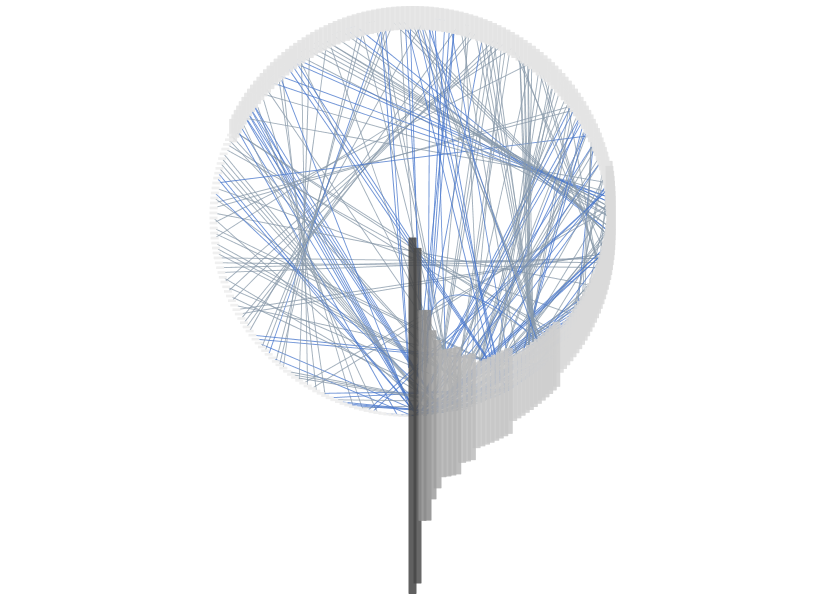

In [12]:
new_cont_mapping = {
    'mappingType': 'continuous',
    'mappingColumn': 'degree.layout',
    'mappingColumnType': 'Integer',
    'visualProperty': 'NODE_HEIGHT',
    'points':[
        {
            'value': 1,
            'lesser': '20',
            'equal': '20',
            'greater': '20'
        },
        {
            'value': 20,
            'lesser': '3000',
            'equal': '3000',
            'greater': '3000'
        }
    ]
}

new_color_mapping = {
    'mappingType': 'continuous',
    'mappingColumn': 'degree.layout',
    'mappingColumnType': 'Integer',
    'visualProperty': 'NODE_FILL_COLOR',
    'points':[
        {
            'value': 1,
            'lesser': '#EEEEEE',
            'equal': '#EEEEEE',
            'greater': '#EEEEEE'
        },
        {
            'value': 20,
            'lesser': '#333333',
            'equal': '#333333',
            'greater': '#333333'
        }
    ]
}
create('styles/default/mappings', [new_cont_mapping, new_color_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

Now you can see the new mapping in the Cytoscape's Control Panel:

![](http://cl.ly/aKNs/cont_mapping1.png)


### Apply Automatic Layout

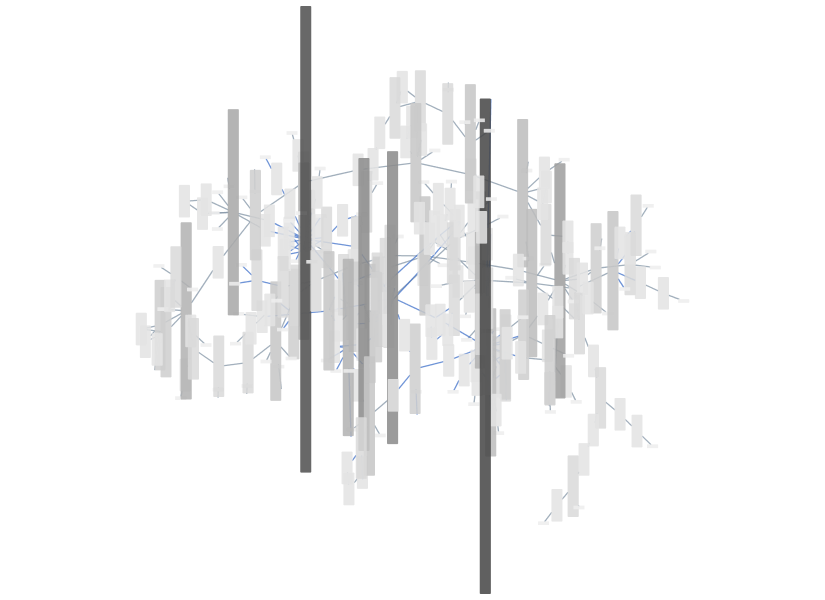

In [13]:
# Apply force-directd layout
requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
Image(BASE+'networks/' + str(suid) + '/views/first.png')

## Discussion
OK, now you can create any mappings from Python.  But editing code like this manyally is a pain...  

### _Don't repeat yourself!_
The true power of __workflow-as-code__ is its reproducibility.  You can easily apply your existing code to other data sets.  The first step to reusability is writing common tasks as functions.

In [14]:
def get_basic_mapping(map_type, column, column_type, vp):
    new_mapping = {
         'mappingType': map_type,
        'mappingColumn': column,
        'mappingColumnType': column_type,
        'visualProperty': vp,
    }
    return new_mapping
    
def get_discrete_mapping(column, column_type, vp):
    mapping = get_basic_mapping('discrete', column, column_type, vp)
    mapping['map'] = []
    return mapping

def get_continuous_mapping(column, column_type, vp):
    mapping = get_basic_mapping('continuous', column, column_type, vp)
    mapping['points'] = []
    return mapping

def get_passthrough_mapping(column, column_type, vp):
    return get_basic_mapping('passthrough', column, column_type, vp)

And now you can do all kinds of crazy thing if you want...

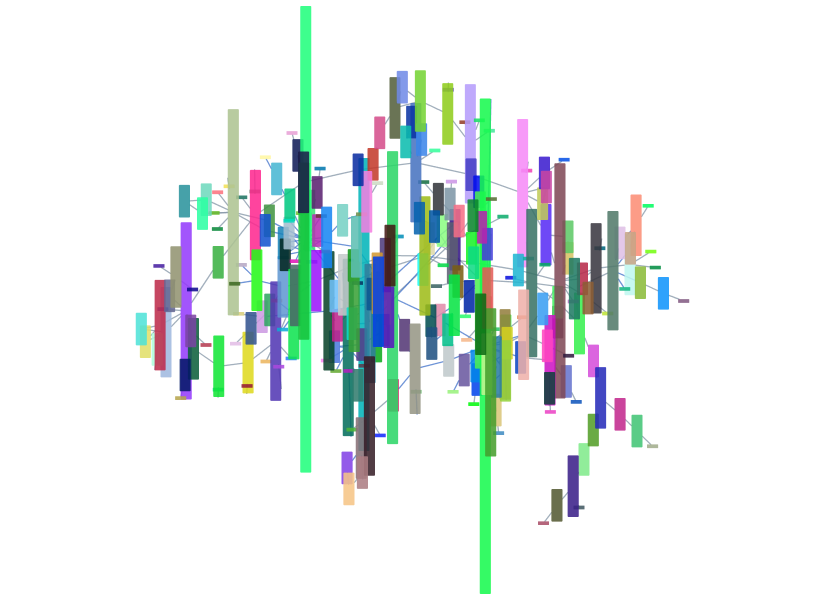

In [15]:
# Find network ID
res = requests.get(BASE + 'networks/' + str(suid) + '/nodes')
node_suids = res.json()

import random

random_colors = []
for node in node_suids:
    entry = {
        'key': str(node),
        'value': '#' + format(random.randint(1,255), 'X') + format(random.randint(1,255), 'X') + format(random.randint(1,255), 'X')
    }
    random_colors.append(entry)
    
random_color_mapping = get_discrete_mapping('SUID', 'Long', 'NODE_FILL_COLOR')
random_color_mapping['map'] = random_colors

create('styles/default/mappings', [random_color_mapping])
Image(BASE+'networks/' + str(suid) + '/views/first.png')

And it is easy to reset it, by simply deleting the mapping.

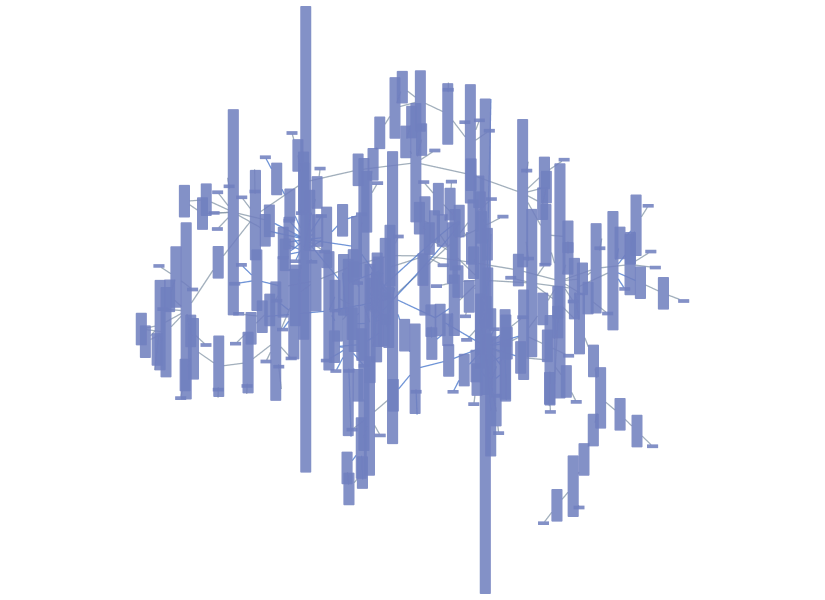

In [16]:
res = requests.delete(BASE + 'styles/default/mappings/NODE_FILL_COLOR')
Image(BASE+'networks/' + str(suid) + '/views/first.png')

#### Is it worth wrting a new Python package?


### Directly Set Visual Properties
In general, Cytoscape visualizations are controlled by _Visual Styles_.  However, in some cases, you may want to edit the view directly.  Typical example is layout.  cyREST provides low level API to access View objects.  In this section, you will learn how to set view values through writing your own layout algorithm.

### Write your own layout algorithm
You can move node (x,y) positions by setting new values for two Visual Properties:
* __NODE_X_LOCATION__
* __NODE_Y_LOCATION__

The following is a simple example to arrange all nodes in one line.

http://137.110.137.158:1234/v1/networks/361346/views/361904.png?h=700


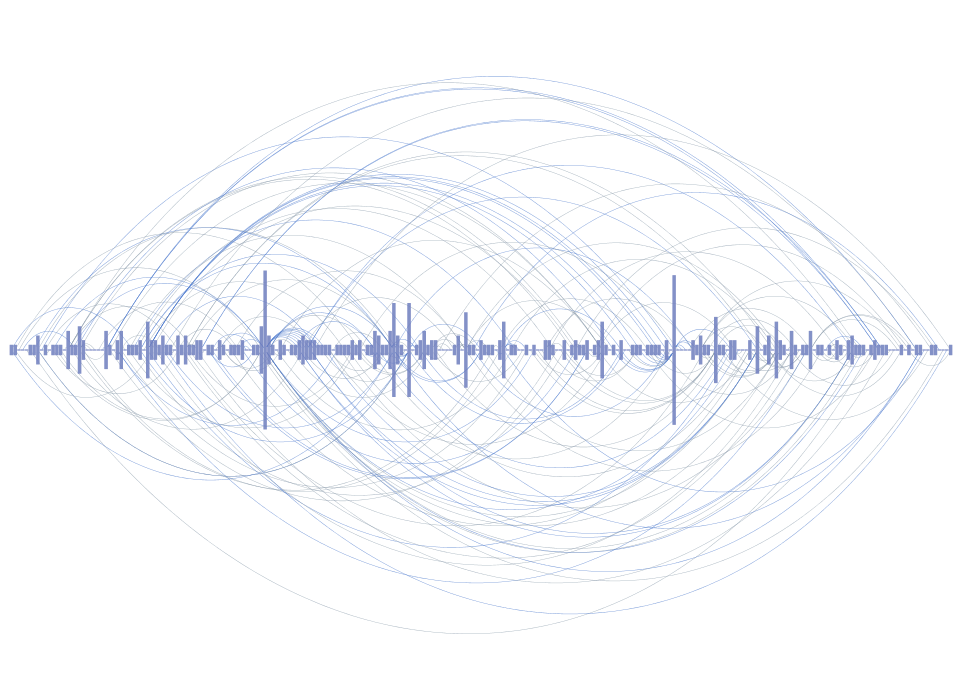

In [17]:
# Find the Network View ID
res = requests.get(BASE + 'networks/' + str(suid) + '/views')
view_id = res.json()[0]
DISPLACEMENT = 64

def linear_layout(suid, node_list):
    # Node X Position = size
    position_list= []
    start_pos = 0
    for node in node_list:
        position = {
            'SUID': node,
            'view':[
                {
                    'visualProperty': 'NODE_X_LOCATION',
                    'value': start_pos
                },
                {
                    'visualProperty': 'NODE_Y_LOCATION',
                    'value': 0
                }
            ]
        }
        position_list.append(position)
        start_pos = start_pos + DISPLACEMENT
    return position_list
    

# Add edge bend information
bend = [
    {
        'visualProperty':'EDGE_BEND',
        'value': '0.5,-0.9,0.9'
    }
]
update('styles/default/defaults', bend)

posx = linear_layout(view_id, node_suids)
node_views_url = 'networks/' + str(suid) + '/views/' + str(view_id) + '/nodes'
res = update(node_views_url, posx)
requests.get(BASE + 'apply/fit/' + str(suid))

image_url = BASE+'networks/' + str(suid) + '/views/' + str(view_id) + '.png?h=700'
print(image_url)
res = requests.get(image_url)
Image(res.content)

In [18]:
res = requests.get(BASE + 'networks/' + str(suid) + '/tables/defaultnode')
rows = res.json()['rows']
node_table_df = pd.DataFrame(rows)
node_table_df.head(10)

SUID  degree_layout   id     name selected shared_name
0  361356              2  465  YIL162W    False     YIL162W
1  361357              2  469  YOR355W    False     YOR355W
2  361358              1  467  YFL038C    False     YFL038C
3  361359              1  477  YML123C    False     YML123C
4  361360              1  480  YHR071W    False     YHR071W
5  361361              2  479  YPL031C    False     YPL031C
6  361362              2  485  YDR009W    False     YDR009W
7  361363              4  483  YML051W    False     YML051W
8  361364              1  490  YML024W    False     YML024W
9  361365              2  488  YIL113W    False     YIL113W

In [19]:
sorted_nodes = node_table_df.sort_index(by=['degree_layout'])
sorted_nodes.tail(10)

SUID  degree_layout   id     name selected shared_name
36   361392              7  388  YPL075W    False     YPL075W
156  361512              7  168  YDR412W    False     YDR412W
130  361486              7  196  YEL009C    False     YEL009C
202  361558              7  110  YJR022W    False     YJR022W
186  361542              8  660  YDR395W    False     YDR395W
120  361476              9  216  YLR362W    False     YLR362W
105  361461             11  231  YPL248C    False     YPL248C
101  361457             11  225  YGL035C    False     YGL035C
175  361531             17  128  YNL216W    False     YNL216W
67   361423             18  286  YMR043W    False     YMR043W

http://137.110.137.158:1234/v1/networks/361346/views/361904.png?h=650


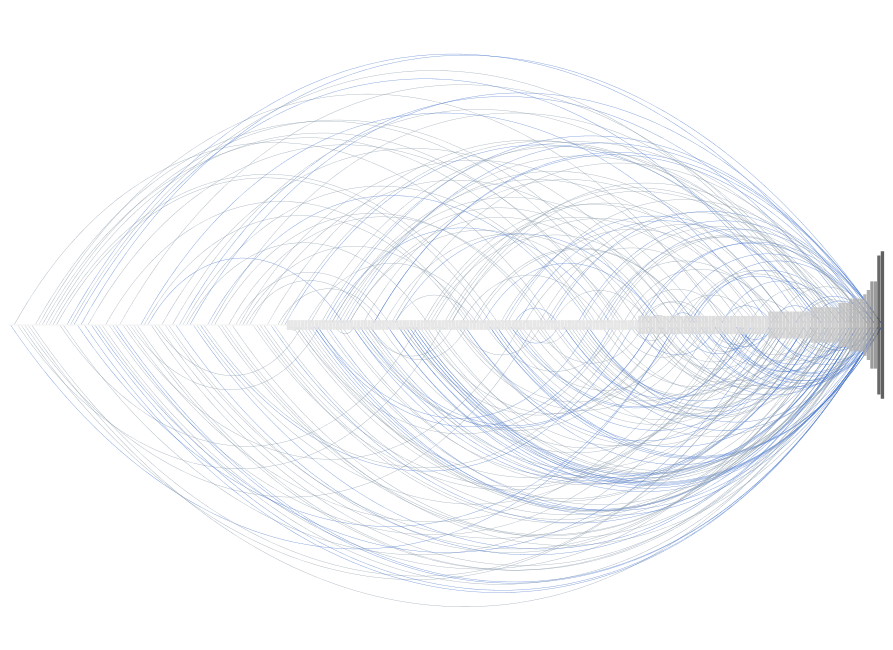

In [20]:
sorted_node_suids = sorted_nodes['SUID']
pos2 = sorted_node_suids.apply(lambda x: str(x))
posx = linear_layout(view_id, pos2.tolist())

res = update(node_views_url, posx)
requests.get(BASE + 'apply/fit/' + str(suid))

create('styles/default/mappings', [new_color_mapping])

image_url = BASE+'networks/' + str(suid) + '/views/' + str(view_id) + '.png?h=650'
print(image_url)
res = requests.get(image_url)

Image(res.content)

## Make it Interactive

Cytoscape project developed new line of Cytoscape family called Cytoscape.js.  It is a JavaScript library to 

In [29]:
# Utilities to convert 3rd party graph objects to Cytoscape.js style JSON 
import py2cytoscape.util as cy

# Package to render networks in Cytoscape.js
from py2cytoscape import cytoscapejs as cyjs

# Apply layout 
requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
current_view = requests.get(BASE + 'networks/' + str(suid) +'/views/first')

# Get visual style file as Cytoscape.js JSON
default_style = requests.get(BASE + 'styles/Directed.json')
cyjs_style = default_style.json()[0]['style']

In [32]:
# Visualize it with Cytoscape.js
cyjs.render(current_view.json(), cyjs_style, 'preset')

In [96]:
default_style = requests.get(BASE + 'styles/Minimal.json')
cyjs_style = default_style.json()[0]['style']

# find Edge default values and perform some ad hock edit
for entry in cyjs_style:
    if entry['selector'] == 'node':
        entry['css']['background-image'] = 'http://opengameart.org/sites/default/files/oga-textures/star.png'
        entry['css']['background-fit'] = 'cover'
        entry['css']['border-width'] =2
        entry['css']['border-color'] ='black'
        entry['css']['content'] =None
        entry['css']['shape'] ='ellipse'
        print(json.dumps(entry, indent=4))
        break

{
    "selector": "node",
    "css": {
        "font-size": 8,
        "width": 50.0,
        "background-opacity": 1.0,
        "background-fit": "cover",
        "font-weight": "normal",
        "background-image": "http://opengameart.org/sites/default/files/oga-textures/star.png",
        "color": "rgb(51,51,51)",
        "height": 50.0,
        "text-opacity": 1.0,
        "text-valign": "center",
        "text-halign": "center",
        "border-color": "black",
        "border-width": 2,
        "border-opacity": 1.0,
        "shape": "ellipse",
        "content": null,
        "background-color": "rgb(255,255,255)",
        "font-family": "SansSerif"
    }
}


In [98]:
cyjs.render(current_view.json(), cyjs_style, 'preset', background='black', height=900)

In [86]:
# Also, you can use built-in preset styles by passing style names
cyjs.render(current_view.json(), 'default2', 'preset', background='radial-gradient(#FFFFFF 15%, #BBBBBB 95%)')

In [99]:
cyjs.render(current_view.json(), 'default2', 'breadthfirst', background='radial-gradient(#FFFFFF 15%, #BBBBBB 95%)')

## Beyond Basics
### Wroking with external libraries

In [156]:
# Generate network data
import networkx as nx

random_graph = nx.powerlaw_cluster_graph(249, 4, 0.03)
communities = list(nx.k_clique_communities(random_graph, 4))

# Create group attribute from this community list
for i, c in enumerate(communities):
    for member in c:
        random_graph.node[member]['community'] = i

cyjs_graph = cy.from_networkx(random_graph)
res2 = create('networks', cyjs_graph)
new_suid = res2.json()['networkSUID']
requests.get(BASE + 'apply/layouts/kamada-kawai/' + str(new_suid))
new_view = requests.get(BASE + 'networks/' + str(new_suid) +'/views/first')

In [157]:
default_style = requests.get(BASE + 'styles/Minimal.json')
minimal_style = default_style.json()[0]['style']

cyjs.render(new_view.json(), minimal_style, 'preset', background='radial-gradient(#FFFFFF 15%, #AAAAAA 95%)', height=900)


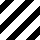
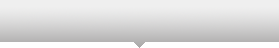
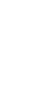
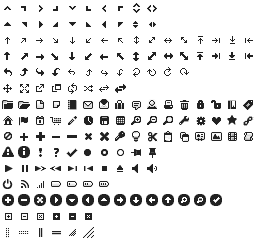
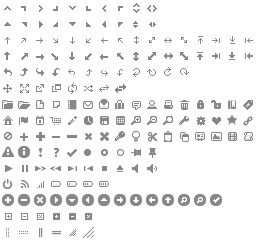
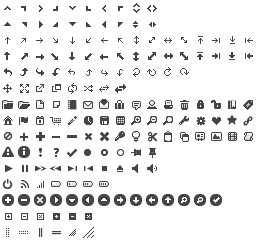
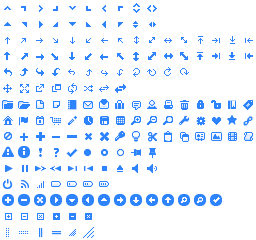
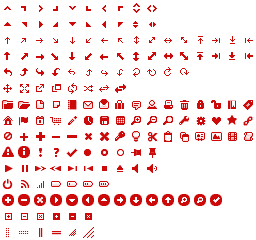
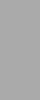
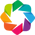
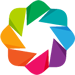
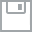
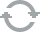
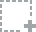
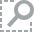
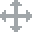
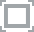
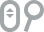

In [120]:
from collections import OrderedDict

import numpy as np
import pandas as pd

from bokeh.charts import Histogram, show
from bokeh.plotting import figure

from bokeh.plotting import output_notebook

output_notebook()

In [158]:
# distributions = OrderedDict(scale_free=degree_sf, random=degree_rd)
yeast = cy.to_networkx(current_view.json())
degree_random = nx.degree(random_graph)
degree_yeast = nx.degree(yeast)
print(degree_random)

new_dg = {}
for d in degree_yeast.keys():
    new_dg[int(d)] = degree_yeast[d]

print(new_dg)

distributions = OrderedDict(random=degree_random, yeast=new_dg)

# create a pandas data frame from the dict
df = pd.DataFrame(distributions)
hist = Histogram(df, bins=20, legend=True)

show(hist)

{0: 38, 1: 18, 2: 23, 3: 21, 4: 39, 5: 47, 6: 42, 7: 18, 8: 22, 9: 10, 10: 37, 11: 17, 12: 9, 13: 28, 14: 11, 15: 13, 16: 11, 17: 19, 18: 36, 19: 9, 20: 19, 21: 7, 22: 20, 23: 6, 24: 15, 25: 13, 26: 14, 27: 10, 28: 24, 29: 10, 30: 15, 31: 14, 32: 14, 33: 6, 34: 18, 35: 8, 36: 11, 37: 10, 38: 14, 39: 19, 40: 9, 41: 9, 42: 7, 43: 5, 44: 8, 45: 9, 46: 7, 47: 8, 48: 5, 49: 17, 50: 12, 51: 8, 52: 4, 53: 17, 54: 7, 55: 12, 56: 11, 57: 13, 58: 9, 59: 7, 60: 8, 61: 9, 62: 9, 63: 10, 64: 7, 65: 12, 66: 8, 67: 8, 68: 12, 69: 11, 70: 8, 71: 4, 72: 7, 73: 4, 74: 8, 75: 6, 76: 8, 77: 9, 78: 9, 79: 5, 80: 9, 81: 7, 82: 6, 83: 6, 84: 9, 85: 6, 86: 6, 87: 9, 88: 8, 89: 13, 90: 9, 91: 8, 92: 6, 93: 6, 94: 8, 95: 6, 96: 6, 97: 6, 98: 6, 99: 4, 100: 7, 101: 5, 102: 4, 103: 8, 104: 8, 105: 5, 106: 6, 107: 7, 108: 6, 109: 4, 110: 5, 111: 6, 112: 6, 113: 6, 114: 6, 115: 4, 116: 4, 117: 5, 118: 6, 119: 8, 120: 7, 121: 4, 122: 9, 123: 5, 124: 6, 125: 8, 126: 4, 127: 4, 128: 4, 129: 6, 130: 6, 131: 10, 132: 4,

## Save the final result as a _Session File_
And now you can save the entire process as Notebooks, and the result as ___Session File___.

In [ ]:
session_file_name = {
    'file': '/Users/kono/Desktop/yeast_session.cys'
}
res = requests.post(BASE + 'session',  params=session_file_name, data=None, headers=HEADERS)
print(json.dumps(res.json(), indent=4))

## Summary
All of the visualizations you created here are reproducible, only with one click (___Run All___ under _Cell_ menu).  In addition, you can reuse the code segments here to make more effective, realistic data visualizations.